<a id="top"></a>
# Cloud Statistics

<hr>

# Notebook Summary

This notebook explores Landsat 7 and Landsat 8 Data Cubes and reports cloud statistics 
for selected regions within a cube. This is valuable information for performing analyses. 
For example, if there are extensive clouds for a season it may significantly impact the 
mosaic product or index values. Another example is that a user may want to find a single 
date when there are few clouds to assess land features.

<hr>

# Index

* Import Dependencies and Connect to the Data Cube
* Choose Platforms and Products
* Get the Extents of the Cube
* Define the Analysis Parameters
* Calculate the Cloud Coverage Percentage for Each Pixel
* Create a Table of Cloud Coverage Percentage for Each Date
* Create a Plot of Cloud Coverage Percentage for Each Date
* Create an Image of the Percent of Clear Views Per Pixel for the Entire Time Period
* Show True Color and False Color Images of a Selected Time Slice

## Import Dependencies and Connect to the Data Cube

In [1]:
# Enable importing of utilities.
import sys
sys.path.append('..')

import numpy as np
import xarray as xr
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import matplotlib.pyplot as plt

# Load Data Cube Configuration
import datacube
import utils.data_access_api as dc_api  
api = dc_api.DataAccessApi()
dc = api.dc

## Choose Platforms and Products

**List available products for each platform**

In [2]:
# Get available products
products_info = dc.list_products()

# List Landsat 7 products.
print("LANDSAT 7 Products:")
products_info[["platform", "name"]][products_info.platform == "LANDSAT_7"]

LANDSAT 7 Products:


,platform,name
id,,
2,LANDSAT_7,ls7_usgs_sr_scene


In [3]:
# List Landsat 8 products.
print("LANDSAT 8 Products:")
products_info[["platform", "name"]][products_info.platform == "LANDSAT_8"]

LANDSAT 8 Products:


,platform,name
id,,
1,LANDSAT_8,ls8_usgs_sr_scene


**Choose products**

<p style="color:red";><b>CHANGE INPUTS BELOW

In [4]:
# These are the platforms (satellites) and products (datacube sets) 
# used for this demonstration.
use_Landsat7 = False
use_Landsat8 = True
platforms = []
products = []
if use_Landsat7:
    platforms.append('LANDSAT_7')
    products.append('ls7_usgs_sr_scene')
if use_Landsat8:
    platforms.append('LANDSAT_8')
    products.append('ls8_usgs_sr_scene')

## Get the Extents of the Cube

In [5]:
from utils.dc_load import get_overlapping_area
from utils.dc_time import dt_to_str

full_lat, full_lon, min_max_dates = get_overlapping_area(api, platforms, products)

# Print the extents of each product.
str_min_max_dates = np.vectorize(dt_to_str)(min_max_dates)
for i, (platform, product) in enumerate(zip(platforms, products)):
    print("For platform {} and product {}:".format(platform, product))
    print("Time Extents:", str_min_max_dates[i])
    print()

# Print the extents of the combined data.
min_start_date_mutual = np.max(min_max_dates[:,0])
max_end_date_mutual = np.min(min_max_dates[:,1])
print("Overlapping Extents:")
print("Latitude Extents:", full_lat)
print("Longitude Extents:", full_lon)
print("Time Extents:", list(map(dt_to_str, (min_start_date_mutual, max_end_date_mutual))))

For platform LANDSAT_8 and product ls8_usgs_sr_scene:
Time Extents: ['2013-03-21' '2020-01-27']

Overlapping Extents:
Latitude Extents: (-12.63361111121218, 18.40166666681388)
Longitude Extents: (-25.47250000020378, 44.01000000035208)
Time Extents: ['2013-03-21', '2020-01-27']


**Visualize the available area**

In [6]:
from utils.dc_display_map import display_map
display_map(full_lat, full_lon)

## Define the Analysis Parameters

<p style="color:red";><b>CHANGE INPUTS BELOW

In [7]:
# Select an analysis region (Lat-Lon) within the extents listed above. 
# Select a time period (Min-Max) within the extents listed above (Year-Month-Day)
# This region and time period will be used for the cloud assessment

# Mombasa, Kenya
latitude = (-4.10, -4.08)
longitude = (39.55, 39.57)

# Mau Forest - Western Kenya
# latitude = (-0.13406, 0.21307)
# longitude = (35.28322, 35.56681)

# Dar es Salaam, Tanzania
# latitude = (-7.0, -6.7)
# longitude = (39.1, 39.4)

# Lake Sulunga, Tanzania
# latitude = (-6.2622, -5.8822) 
# longitude = (34.9802, 35.3602) 

# Freetown, Sierra Leone
# latitude = (8.3267, 8.5123)
# longitude = (-13.3109, -13.1197 )

# Vietnam
# latitude = (10.9358, 11.0358)
# longitude = (107.1899, 107.2899)

# Ghanas
# latitude = (5.5, 5.7)   # Accra
# longitude = (-0.4, 0.0) # Accra

# Time Period
time_extents = ('2015-01-01', '2015-12-31')

**Visualize the selected area**

In [8]:
display_map(latitude,longitude)

## Calculate the Cloud Coverage Percentage for Each Pixel

In [9]:
from utils.dc_load import match_dim_sizes, is_dataset_empty
from utils.clean_mask import landsat_qa_clean_mask, landsat_clean_mask_invalid
from utils.aggregate import xr_scale_res
from utils.sort import xarray_sortby_coord

def build_cloud_coverage_table_landsat(products,
                                       platforms,
                                       latitude,
                                       longitude,
                                       time     = None,
                                       dc       = None,
                                       extra_band = 'green'):
    dc = dc if dc is not None else datacube.Datacube(app = "")
    
    matching_abs_res, same_dim_sizes = match_dim_sizes(dc, products, longitude, latitude)
    
    datasets = {}
    clean_masks = {}
    for platform, product in zip(platforms, products):
        # Load the dataset.
        dataset = dc.load(platform=platform, product=product, lat=latitude, lon=longitude, 
                          time=time_extents, measurements=[extra_band, 'pixel_qa'],
                          group_by='solar_day', dask_chunks={'time':1}).compute()
        print(dataset)
        if is_dataset_empty(dataset):
            continue
        
        # Get the masks (varies by platform).
        clean_mask = (landsat_qa_clean_mask(dataset, platform) & 
                      (dataset != -9999).to_array().all('variable') & 
                      landsat_clean_mask_invalid(dataset))
        
        # If needed, scale the datasets and clean masks to the same size in the x and y dimensions.
        if not same_dim_sizes:    
            dataset = xr_scale_res(dataset, abs_res=matching_abs_res)
            clean_mask = xr_scale_res(clean_mask.astype(np.uint8), 
                                      abs_res=matching_abs_res).astype(np.bool)
        # Clean the data.
        dataset = dataset.where(clean_mask)
        datasets[product], clean_masks[product] = dataset, clean_mask
    # Combine everything.
    if len(datasets) > 0:
        # Make the coordinates of the datasets the same as the first.
        for i in range(1, len(platforms)):
            for coord in ['latitude', 'longitude']:
                datasets[platforms[i]][coord].values = \
                    datasets[platforms[0]][coord].values
        dataset = xarray_sortby_coord(xr.concat(list(datasets.values()), dim='time'), coord='time')
        clean_mask = xarray_sortby_coord(xr.concat(list(clean_masks.values()), dim='time'), coord='time')
    else:
        dataset = xr.Dataset()
        clean_mask = xr.DataArray(np.empty((0,), dtype=np.bool))
    del datasets, clean_masks
    
    times = list(dataset.time.values)
    scene_slice_list = list(map(lambda t: dataset.sel(time = t), times))
    
    clean_mask_list = [clean_mask.sel(time=time).values for time in clean_mask.time]
    no_data_mask_list = list(map(lambda ds: (ds[extra_band]==-9999).values, scene_slice_list))
    # Calculate the percentage of all pixels which are not cloud.
    percentage_list = [clean_mask.mean()*100 for clean_mask in clean_mask_list]
    clean_pixel_count_list = list(map(np.sum, clean_mask_list))
    
    data = {"times": times,
            "clean_percentage": percentage_list,
            "clean_count": clean_pixel_count_list }
    
    return dataset, pd.DataFrame(data=data, columns = ["times", "clean_percentage", "clean_count"])

In [10]:
extra_band = 'green'
landsat_dataset, coverage_table = build_cloud_coverage_table_landsat(products = products,
                                                                     platforms = platforms,
                                                                     latitude = latitude,
                                                                     longitude = longitude,
                                                                     time = time_extents,
                                                                     extra_band=extra_band)

<xarray.Dataset>
Dimensions:    (latitude: 73, longitude: 73, time: 19)
Coordinates:
  * time       (time) datetime64[ns] 2015-01-07T07:31:40.460727 ... 2015-12-25T07:31:45.532103
  * latitude   (latitude) float64 -4.08 -4.08 -4.08 -4.081 ... -4.099 -4.1 -4.1
  * longitude  (longitude) float64 39.55 39.55 39.55 39.55 ... 39.57 39.57 39.57
Data variables:
    green      (time, latitude, longitude) int16 6688 6633 6605 ... 2490 1386
    pixel_qa   (time, latitude, longitude) uint16 992 992 992 ... 480 480 416
Attributes:
    crs:      EPSG:4326


## Create a Table of Cloud Coverage Percentage for Each Date

In [11]:
pd.set_option('display.max_rows', len(coverage_table))
coverage_table

,times,clean_percentage,clean_count
0,2015-01-07 07:31:40.460727,0.000000,0
1,2015-01-23 07:31:34.009669,0.000000,0
2,2015-02-08 07:31:30.894427,0.000000,0
3,2015-02-24 07:31:25.484858,100.000000,5329
4,2015-03-12 07:31:14.003261,0.619253,33
5,2015-03-28 07:31:06.151168,0.000000,0
6,2015-04-13 07:31:00.288607,49.296303,2627
7,2015-04-29 07:30:53.024505,0.000000,0
8,2015-05-15 07:30:37.649251,68.136611,3631
9,2015-06-16 07:30:54.954621,0.000000,0


## Create a Plot of Cloud Coverage Percentage for Each Date

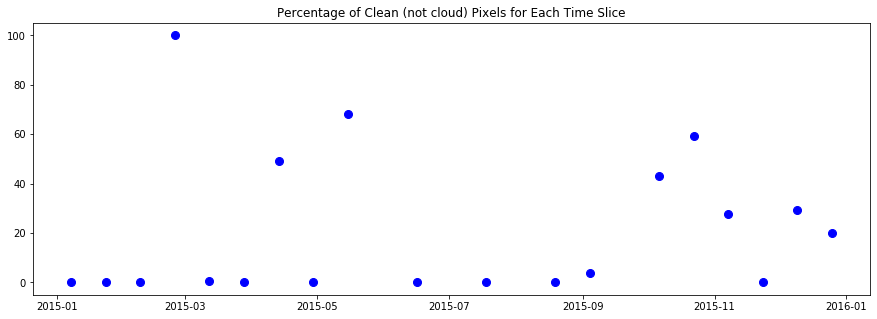

In [12]:
plt.figure(figsize = (15,5))
plt.plot(coverage_table["times"].values, coverage_table["clean_percentage"].values, 'bo', markersize=8)
plt.title("Percentage of Clean (not cloud) Pixels for Each Time Slice")
plt.show()

## Create an Image of the Percent of Clear Views Per Pixel for the Entire Time Period

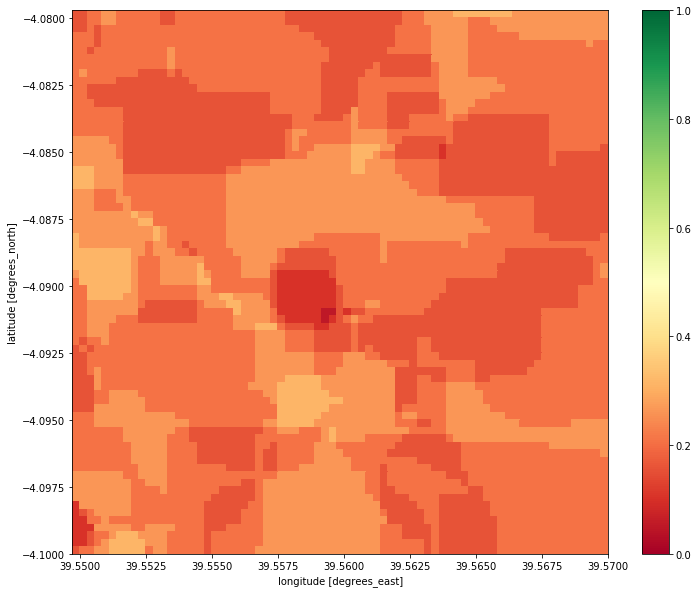

In [13]:
from utils.clean_mask import landsat_qa_clean_mask
from utils.plotter_utils import create_gradient_color_map
from utils.plotter_utils import xarray_imshow

# We are really plotting the fraction of times that are not no_data which are clear.
# This is done to account for regions filled with no_data  - such as when querying across path/rows.
data_mask = (landsat_dataset[extra_band] != -9999)
clean_mask = landsat_qa_clean_mask(landsat_dataset, platform)
merged_mask = clean_mask & data_mask
clear_and_data_per_px = merged_mask.sum(dim='time')
data_per_px = data_mask.sum(dim='time')
frac_clear_per_data_per_px = clear_and_data_per_px / data_per_px
num_cbar_ticks = 8 # The number of ticks to use for the colorbar.
quad_mesh = (frac_clear_per_data_per_px).plot(figsize=(12,10),cmap = "RdYlGn", vmin=0, vmax=1)
plt.show()

In [14]:
print("Percent of pixels with data: {:.2%}".format(data_mask.mean().values))
print("Percent of pixels that are clear: {:.2%}".format(clean_mask.mean().values))
print("Percent of pixels that are clear and have data: {:.2%}".format(merged_mask.mean().values))

Percent of pixels with data: 100.00%
Percent of pixels that are clear: 21.13%
Percent of pixels that are clear and have data: 21.13%


In [15]:
(frac_clear_per_data_per_px == 0).sum() / frac_clear_per_data_per_px.count()
print("Number of pixels which have no non-cloud data:", (frac_clear_per_data_per_px == 0).sum().values)
print("Total number of pixels:", frac_clear_per_data_per_px.count().values)

Number of pixels which have no non-cloud data: 0
Total number of pixels: 5329


## Show True Color and False Color Images of a Selected Time Slice

In [16]:
# Load the data to create an RGB image
measurements = ['red', 'green', 'blue', 'nir', 'swir1', 'swir2']
landsat_dataset = dc.load(latitude = latitude,
                          longitude = longitude,
                          platform = platform,
                          time = time_extents,
                          product = product,
                          measurements = measurements,
                          group_by='solar_day', dask_chunks={'time':1}).compute()

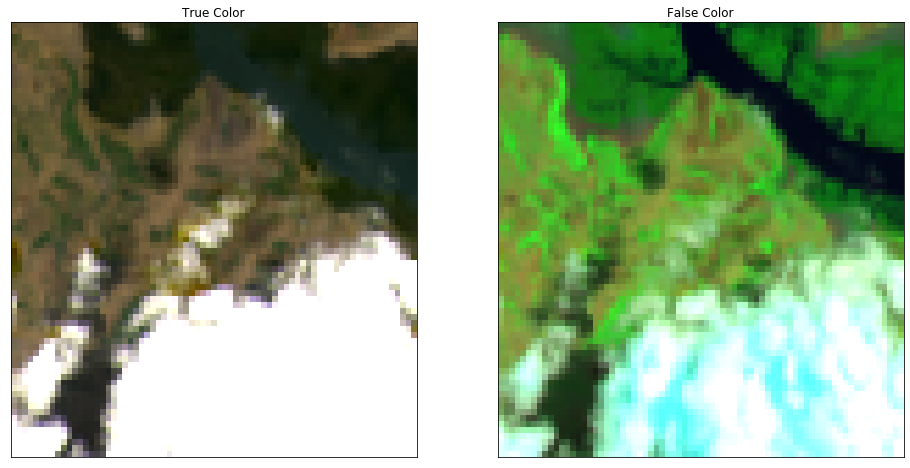

In [17]:
from utils.dc_rgb import rgb

time_ind = 6 # The acquisition to select. The first acquisition has index 0.

# Select one of the time slices and create an RGB image. 
# Time slices are numbered from 0 to x and shown in the table above
# Review the clean_percentage values above to select scenes with few clouds
# Clouds will be visible in WHITE and cloud-shadows will be visible in BLACK

fig, ax = plt.subplots(1, 2, figsize=(16, 8))
true_rgb = landsat_dataset.isel(time=time_ind)[['red', 'green', 'blue']].to_array()
false_rgb = landsat_dataset.isel(time=time_ind)[['swir2', 'nir', 'green']].to_array()
true_rgb.plot.imshow(ax=ax[0], vmin=0, vmax=3000)
false_rgb.plot.imshow(ax=ax[1], vmin=0, vmax=5000)
ax[0].set_title('True Color'), ax[0].xaxis.set_visible(False), ax[0].yaxis.set_visible(False)
ax[1].set_title('False Color'), ax[1].xaxis.set_visible(False), ax[1].yaxis.set_visible(False)
plt.show()